In [71]:
import re
import os
from collections import Counter

import numpy as np

import matplotlib.pyplot as plt

import nltk
import email
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

In [72]:
seed = 42
def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)#seeting up torch seed
    np.random.seed(seed)#setting up numpy seed
set_seed(seed)
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Asus Zenbook
[nltk_data]     Flip\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [73]:
for filename in os.listdir(os.path.abspath("spam")):
    try:
        with open(os.path.join("spam", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("spam", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("spam", filename), "w", encoding="utf-8") as file:
            file.write(content)
for filename in os.listdir(os.path.abspath("ham")):
    try:
        with open(os.path.join("ham", filename), "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        with open(os.path.join("ham", filename), "r", encoding="latin-1") as file:
            content = file.read()
        with open(os.path.join("ham", filename), "w", encoding="utf-8") as file:
            file.write(content)

In [74]:
class clean_dataset(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None): 
        return self
    
    def process(self, mail):
        stemmer = PorterStemmer()
        lemmatizer = WordNetLemmatizer()

        b = email.message_from_string(mail)
        body = ""
        if b.is_multipart():
            for part in b.walk():
                ctype = part.get_content_type()
                cdispo = str(part.get('Content-Disspamition'))
                if ctype == 'text/plain' and 'attachment' not in cdispo:
                    body = part.get_payload(decode=True)  
                    break
        else:
            body = b.get_payload(decode=True) # récupérer le corp de l'email

        #HTML
        soup = BeautifulSoup(body, "html.parser") 

        #lower case
        text = soup.get_text().lower()

        #dollars
        text = text.replace('$', " dollar ")

        #URLs
        text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', 'httpaddr', text, flags=re.MULTILINE)

        #emails
        text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', 'emailaddr', text, flags=re.MULTILINE) 

        #punctuation
        text = text.translate(str.maketrans('', '', string.punctuation)) 
        
        #numbers
        text = re.sub(r'\d+', 'nombre', text, flags=re.MULTILINE)

        # tokenize
        tokenizer = nltk.tokenize.TreebankWordTokenizer()
        tokens = tokenizer.tokenize(text)

        # stemming
        stemmer = nltk.stem.snowball.SnowballStemmer("english")
        tokens = [stemmer.stem(text) for token in tokens if text.isalpha()]
        
        #vocabulary
        nltk.download('stopwords', quiet=True)
        stopwords = nltk.corpus.stopwords.words('english')
        raw_vocab=text.split()
        raw_vocab = [x for x in raw_vocab if x not in stopwords] 

        return raw_vocab

In [75]:
em = clean_dataset()
raw_vocab = []
spam_raw_vocab = []
ham_raw_vocab = []

spam = 0
ham = 0

#creation of the spam vocabulary
for filename in os.listdir(os.path.abspath("spam")):
    with open(os.path.join("spam", filename), "r", encoding="utf-8") as file_content:
        tokens = em.process(file_content.read())
        spam_raw_vocab += tokens#.split()
        spam += 1

#creation of the ham vocabulary
for filename in os.listdir(os.path.abspath("ham")):
    with open(os.path.join("ham", filename), "r", encoding="utf-8") as file_content:
        tokens = em.process(file_content.read())
        ham_raw_vocab += tokens
        ham += 1

raw_vocab = ham_raw_vocab + spam_raw_vocab
print("There are", len(raw_vocab), "tokens in the raw vocabulary")

C:\Users\Asus Zenbook Flip\AppData\Local\Temp\ipykernel_21968\3968768072.py:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(body, "html.parser")
C:\Users\Asus Zenbook Flip\AppData\Local\Temp\ipykernel_21968\3968768072.py:26: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(body, "html.parser")
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


There are 560314 tokens in the raw vocabulary


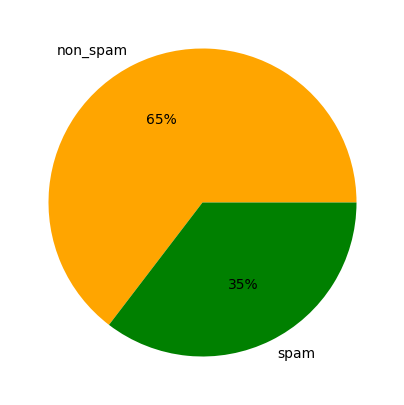

(1397, 2551)

In [76]:
data = [ham/(ham + spam), spam/(ham + spam)]
labels = ['non_spam', 'spam']
colors = ['orange', 'green']
plt.figure(figsize=(12, 5))
plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()
spam,ham

In [77]:
#reducing the vocabulary to the 5000 most frequent words only
vocabulary_size = 5000
bag_of_words = Counter(raw_vocab)
vocab = [x[0] for x in bag_of_words.most_common(vocabulary_size)]
print("There are", len(vocab), "different tokens after cleaning")

There are 5000 different tokens after cleaning


In [78]:
#keeping words that appear at least 20 times 
K = 20 #hna ilies der vocab te3 raw_vocab y3ni spam w ham, bsh prof 9alt fl'ennoce te3 spam brk, wten der most common words y3ni meshi b K, lzm b K
vocab = []
for word in set(spam_raw_vocab):
    if raw_vocab.count(word) == K:
        vocab.append(word)

In [79]:
len(vocab)

112

In [80]:
#creating the vocabulary file (dictionary)
with open("vocab.txt", "w", encoding="utf-8") as f:
    for word in vocab:
        f.write(word + "\n")

In [81]:
#Mapping
word_to_index = {}
index_to_word = {}
for index, word in enumerate(vocab): #assign index to words in vocab
    word_to_index[word] = index + 1 #index=word
    index_to_word[index + 1] = word #index=number

In [82]:
#for this function ilies khdm biha fhis class "MailDataset" bsh idk elle sert a quoi apres, we'll see ida s7a9inaha
#La fonction prend une liste de tokens en entrée et renvoie une liste d'entiers encodant ces tokens en utilisant un dictionnaire word_to_index qui associe chaque mot à un indice unique. La fonction filtre également les tokens qui ne sont pas présents dans le dictionnaire word_to_index.
def transform(tokens):
    #what about raw_vocab(exluding and,ect) and taking only >5000
    encoded_tokens = [word_to_index.get(word, 0) for word in tokens if word in word_to_index]
    return encoded_tokens

In [83]:
raw_vocab[1]

'wed'

In [84]:
class MailDataset(Dataset):
    def __init__(self, 
            spam_files,
            ham_files,
            transform=transform,
            spam_class_dir="spam",
            ham_class_dir="ham"):
        
        self.spam_class_dir = spam_class_dir
        self.ham_class_dir = ham_class_dir
        self.spam_files = spam_files
        self.ham_files = ham_files
        self.transform = transform
        #list of tuples (mail, label), mail == encoded tokens, lable == 0 for ham & 1 for spam
        self.mails = []

        #tokenize and encode the spam emails and updating mails list
        for file in self.spam_files:
            mail_path = os.path.join(self.spam_class_dir, file)
            label = 1
            with open(mail_path, "r", encoding="utf-8") as file:
                mail = [0] + transform(file)
            self.mails.append((mail, label))

        #tokenize and encode the ham emails and updating mails list
        for file in self.ham_files:
            mail_path = os.path.join(self.ham_class_dir, file)
            label = 0
            with open(mail_path, "r", encoding="utf-8") as file:
                mail = [0] + transform(file)
            self.mails.append((mail, label))
    
    #returns the length of the dztaset
    def __len__(self):
        return len(self.mails)
    
    #returns the email (and its label) at the idx index as a tensor(vector)
    def __getitem__(self, idx):
        mail, label = self.mails[idx]
        return torch.unsqueeze(torch.as_tensor(mail), dim=-1).float(), torch.as_tensor(label).float()

In [85]:
def create_train_test_dataset(
        test_size = 0.3,
        spam_class_dir="spam",
        ham_class_dir="ham"):
    
    spam_files = os.listdir(os.path.abspath(spam_class_dir))
    ham_files = os.listdir(os.path.abspath(ham_class_dir))
    
    
    shuffled_spam_indices = np.random.permutation(len(spam_files))
    shuffled_ham_indices = np.random.permutation(len(ham_files))

    spam_test_set_size = int(len(spam_files) * test_size)
    ham_test_set_size = int(len(ham_files) * test_size)
    
    spam_train_indices = shuffled_spam_indices[spam_test_set_size:]
    spam_test_indices = shuffled_spam_indices[:spam_test_set_size]
    
    ham_train_indices = shuffled_ham_indices[ham_test_set_size:]
    ham_test_indices = shuffled_ham_indices[:ham_test_set_size]
    
    spam_train_files = [spam_files[i] for i in spam_train_indices]
    ham_train_files = [ham_files[i] for i in ham_train_indices]
    
    spam_test_files = [spam_files[i] for i in spam_test_indices]
    ham_test_files = [ham_files[i] for i in ham_test_indices]
    
    train_dataset = MailDataset(spam_train_files, ham_train_files)
    test_dataset = MailDataset(spam_test_files, ham_test_files)
    
    return train_dataset, test_dataset

In [86]:
train_dataset, test_dataset = create_train_test_dataset()

In [87]:
#binary representation of features 
def email_bin_embedding(email):
    embedding = np.zeros((1, vocabulary_size))
    for word_index in email:
        if (word_index.int().item() > 0):
            embedding[0, word_index.int().item() - 1] = 1
    return embedding

In [88]:
train_full = np.asarray([np.append(email_bin_embedding(x[0]), x[1].item()) for x in train_dataset])
train_X, train_y = train_full[:, :-1], train_full[:, -1]

test_full = np.asarray([np.append(email_bin_embedding(x[0]), x[1].item()) for x in test_dataset])
test_X, test_y = test_full[:, :-1], test_full[:, -1]


print("train set: x {}, y {}\ntest set: x {}, y {}".format(train_X.shape, train_y.shape, test_X.shape, test_y.shape))

train set: x (2764, 5000), y (2764,)
test set: x (1184, 5000), y (1184,)


In [89]:
from sklearn import svm
bin_svm_model = svm.SVC(C=0.1, kernel="linear", random_state=seed)
bin_svm_model.fit(train_X, train_y)

SVC(C=0.1, kernel='linear', random_state=42)

In [90]:
train_prediction = bin_svm_model.predict(train_X)
test_prediction = bin_svm_model.predict(test_X)

train_accuracy = (train_prediction == train_y).mean() * 100
test_accuracy = (test_prediction == test_y).mean() * 100

print("test accuracy: {0:.10f}%".format(test_accuracy))

train accuracy: 64.6164978292%
test accuracy: 64.6114864865%


with threshold = 0.0 | test accuracy is 64.61%


Text(0.5, 0, 'False positive rate')

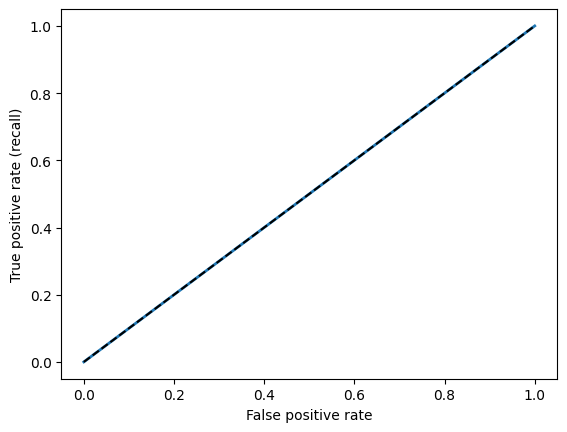

In [91]:
rain_prediction_scores = bin_svm_model.decision_function(train_X)
test_prediction_scores = bin_svm_model.decision_function(test_X)

fpr, tpr, thresholds = roc_curve(test_y, test_prediction_scores)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = thresholds[ix]
test_prediction = np.asarray([ 1 if x > threshold else 0 for x in test_prediction_scores])
print("with threshold = {0} | test accuracy is {1:.2f}%"
      .format(threshold, (test_prediction==np.asarray(test_y)).mean() * 100))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.ylabel("True positive rate (recall)")
plt.xlabel("False positive rate")